In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import string
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

df = pd.read_csv('20newsgroups.csv', names=['Text','Label'], skiprows=1)

c:\Users\Axioo Pongo\anaconda3\envs\Stable\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df.head()

,Text,Label
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


In [3]:
def simplify_text(email_text):
    def extract_body(email_text):
        parts = email_text.split('\n\n', 1)
        if len(parts) > 1:
            body = parts[1].strip()
            body = re.split(r'\n--', body, maxsplit=1)[0].strip()
            body = body.replace('\n', ' ')
            return body
        return email_text

    def remove_before_writes(text):
        if "writes:" in text:
            return text.rsplit("writes:",1)[1].strip()
        if "says:" in text:
            return text.rsplit("says:",1)[1].strip()
        if "wrote:" in text:
            return text.rsplit("wrote:",1)[1].strip()
        return text

    def remove_before_edu(text):
        if ".edu," in text:
            return text.split(".edu,")[1].strip()
        return text

    def clean_repeated_punctuation_and_spaces(text):
        cleaned_text = re.sub(r'([.,!?;:-])\1+', r'\1', text)
        # Replace multiple spaces with a single space
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
        # Strip leading and trailing spaces
        cleaned_text = cleaned_text.strip()
        return cleaned_text
    
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation.replace('.', '').replace(',', '').replace('?', '').replace('!', '')))

    def remove_websites_with_specific_domains(text):
        website_pattern = r'\S+(\.com|\.edu|\.org)\b|\bwww\.\S+?(\.com|\.edu|\.EDU|\.org)\b'
        # Menghapus URL dari teks
        return re.sub(website_pattern, '', text, flags=re.IGNORECASE).strip()
    
    def remove_punctuation_start(text):
        return re.sub(r'^[^\w\s]+', '', text)

    email_text = extract_body(email_text)
    email_text = remove_before_writes(email_text)
    email_text = remove_before_edu(email_text)
    email_text = remove_punctuation(email_text)
    email_text = clean_repeated_punctuation_and_spaces(email_text)
    email_text = remove_websites_with_specific_domains(email_text)
    email_text = remove_punctuation_start(email_text)
    return email_text

# Terapkan fungsi simplify_text ke kolom 'Text'
df['Text'] = df['Text'].apply(simplify_text)
df = df[df['Text'] != ''].drop(columns=['Label'])

In [5]:
# doc_lengths = []

# for bio in df['Text']:

#     # get rough token count distribution
#     tokens = nltk.word_tokenize(bio)

#     doc_lengths.append(len(tokens))

# doc_lengths = np.array(doc_lengths)

# plt.figure(figsize=(15, 4))
# sns.histplot(doc_lengths, kde=True)
# plt.xlabel('Document Length')
# plt.ylabel('Frequency')
# plt.title('Distribution of Document Lengths')
# plt.show()

In [6]:
# len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

In [7]:
# doc_lengths.mean()

In [7]:
from datasets import Dataset
df = Dataset.from_pandas(df)

pretrained = 'gpt2'
config = AutoConfig.from_pretrained(pretrained)
model = AutoModelForCausalLM.from_pretrained(pretrained, config=config)
tokenizer = AutoTokenizer.from_pretrained(pretrained)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    tokenized = tokenizer(
        examples["Text"], 
        padding="max_length", 
        truncation=True, 
        max_length=256,
        return_tensors="pt" )

    tokenized["labels"] = tokenized["input_ids"].clone()

    return tokenized

# Tokenize the dataset
tokenized_dataset = df.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map: 100%|██████████| 18807/18807 [00:03<00:00, 5652.62 examples/s]


In [8]:
split_datasets = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

train_val_split = split_datasets["train"].train_test_split(test_size=0.125, seed=42)  # 0.125 = 10% dari keseluruhan data

train_dataset = train_val_split["train"]
val_dataset = split_datasets["test"]
test_dataset = train_val_split["test"]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 13164
Validation dataset size: 3762
Test dataset size: 1881


In [9]:
from transformers import Trainer, TrainingArguments

# Define training arguments
args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    learning_rate=1e-5,
    fp16=True,
    logging_dir='./logs',          # Directory to save logs
    logging_strategy="epoch",      # Log after each epoch
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

 10%|█         | 1097/10970 [05:39<52:17,  3.15it/s]

{'loss': 2.6699, 'grad_norm': 3.85319185256958, 'learning_rate': 9.006381039197814e-06, 'epoch': 1.0}


                                                    
 10%|█         | 1097/10970 [06:42<52:17,  3.15it/s]

{'eval_loss': 2.4873876571655273, 'eval_runtime': 62.9253, 'eval_samples_per_second': 59.785, 'eval_steps_per_second': 59.785, 'epoch': 1.0}


 20%|██        | 2194/10970 [12:30<46:03,  3.18it/s]   

{'loss': 2.5495, 'grad_norm': 2.9630701541900635, 'learning_rate': 8.006381039197813e-06, 'epoch': 2.0}


                                                    
 20%|██        | 2194/10970 [13:28<46:03,  3.18it/s]

{'eval_loss': 2.4551479816436768, 'eval_runtime': 57.6695, 'eval_samples_per_second': 65.234, 'eval_steps_per_second': 65.234, 'epoch': 2.0}


 30%|███       | 3291/10970 [19:16<41:06,  3.11it/s]   

{'loss': 2.5027, 'grad_norm': 3.7646327018737793, 'learning_rate': 7.0063810391978126e-06, 'epoch': 3.0}


                                                    
 30%|███       | 3291/10970 [20:07<41:06,  3.11it/s]

{'eval_loss': 2.434325933456421, 'eval_runtime': 50.8084, 'eval_samples_per_second': 74.043, 'eval_steps_per_second': 74.043, 'epoch': 3.0}


 40%|████      | 4388/10970 [25:56<34:44,  3.16it/s]   

{'loss': 2.4698, 'grad_norm': 3.5735738277435303, 'learning_rate': 6.006381039197813e-06, 'epoch': 4.0}


                                                    
 40%|████      | 4388/10970 [26:48<34:44,  3.16it/s]

{'eval_loss': 2.4191322326660156, 'eval_runtime': 51.8885, 'eval_samples_per_second': 72.502, 'eval_steps_per_second': 72.502, 'epoch': 4.0}


 50%|█████     | 5485/10970 [32:37<28:45,  3.18it/s]   

{'loss': 2.4428, 'grad_norm': 3.405158281326294, 'learning_rate': 5.006381039197813e-06, 'epoch': 5.0}


                                                    
 50%|█████     | 5485/10970 [33:28<28:45,  3.18it/s]

{'eval_loss': 2.408226728439331, 'eval_runtime': 50.9576, 'eval_samples_per_second': 73.826, 'eval_steps_per_second': 73.826, 'epoch': 5.0}


 60%|██████    | 6582/10970 [39:15<22:51,  3.20it/s]   

{'loss': 2.4218, 'grad_norm': 2.710315704345703, 'learning_rate': 4.0063810391978125e-06, 'epoch': 6.0}


                                                    
 60%|██████    | 6582/10970 [40:04<22:51,  3.20it/s]

{'eval_loss': 2.399327278137207, 'eval_runtime': 49.0646, 'eval_samples_per_second': 76.674, 'eval_steps_per_second': 76.674, 'epoch': 6.0}


 70%|███████   | 7679/10970 [45:52<17:15,  3.18it/s]   

{'loss': 2.4063, 'grad_norm': 3.1187360286712646, 'learning_rate': 3.0063810391978128e-06, 'epoch': 7.0}


                                                    
 70%|███████   | 7679/10970 [46:43<17:15,  3.18it/s]

{'eval_loss': 2.3938584327697754, 'eval_runtime': 50.5492, 'eval_samples_per_second': 74.423, 'eval_steps_per_second': 74.423, 'epoch': 7.0}


 80%|████████  | 8776/10970 [52:31<11:39,  3.14it/s]   

{'loss': 2.394, 'grad_norm': 2.889619827270508, 'learning_rate': 2.006381039197812e-06, 'epoch': 8.0}


                                                    
 80%|████████  | 8776/10970 [53:20<11:39,  3.14it/s]

{'eval_loss': 2.3896090984344482, 'eval_runtime': 49.4743, 'eval_samples_per_second': 76.039, 'eval_steps_per_second': 76.039, 'epoch': 8.0}


 90%|█████████ | 9873/10970 [59:08<05:46,  3.17it/s]  

{'loss': 2.3858, 'grad_norm': 2.345768451690674, 'learning_rate': 1.0063810391978122e-06, 'epoch': 9.0}


                                                    
 90%|█████████ | 9873/10970 [59:58<05:46,  3.17it/s]

{'eval_loss': 2.3871688842773438, 'eval_runtime': 49.7122, 'eval_samples_per_second': 75.676, 'eval_steps_per_second': 75.676, 'epoch': 9.0}


100%|██████████| 10970/10970 [1:05:48<00:00,  3.14it/s] 

{'loss': 2.3809, 'grad_norm': 2.765937328338623, 'learning_rate': 6.381039197812216e-09, 'epoch': 10.0}


                                                       
100%|██████████| 10970/10970 [1:06:38<00:00,  3.14it/s]

{'eval_loss': 2.3864810466766357, 'eval_runtime': 50.1964, 'eval_samples_per_second': 74.946, 'eval_steps_per_second': 74.946, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
100%|██████████| 10970/10970 [1:06:40<00:00,  2.74it/s]

{'train_runtime': 4000.8198, 'train_samples_per_second': 32.903, 'train_steps_per_second': 2.742, 'train_loss': 2.46235565213366, 'epoch': 10.0}


TrainOutput(global_step=10970, training_loss=2.46235565213366, metrics={'train_runtime': 4000.8198, 'train_samples_per_second': 32.903, 'train_steps_per_second': 2.742, 'total_flos': 1.719824154624e+16, 'train_loss': 2.46235565213366, 'epoch': 10.0})

In [10]:
# Evaluate BLEU score on train dataset

model = model.to("cuda")
train_results = trainer.evaluate(eval_dataset=train_dataset, metric_key_prefix="train")
val_results = trainer.evaluate(eval_dataset=val_dataset, metric_key_prefix="val")
test_results = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

print(f"Train loss      : {train_results['train_loss']}")
print(f"Validation loss : {val_results['val_loss']}")
print(f"Test loss       : {test_results['test_loss']}")

100%|██████████| 1881/1881 [00:26<00:00, 71.86it/s]

Train loss      : 2.293651580810547
Validation loss : 2.3864810466766357
Test loss       : 2.4240665435791016


In [11]:
import math

def calculate_ppl(loss):
    return math.exp(loss)

train_ppl = calculate_ppl(train_results['train_loss'])
val_ppl = calculate_ppl(val_results['val_loss'])
test_ppl = calculate_ppl(test_results['test_loss'])

print(f"Train PPL       : {train_ppl}")
print(f"Validation PPL  : {val_ppl}")
print(f"Test PPL        : {test_ppl}")

Train PPL       : 9.911062730742927
Validation PPL  : 10.875157359146499
Test PPL        : 11.291684203173237


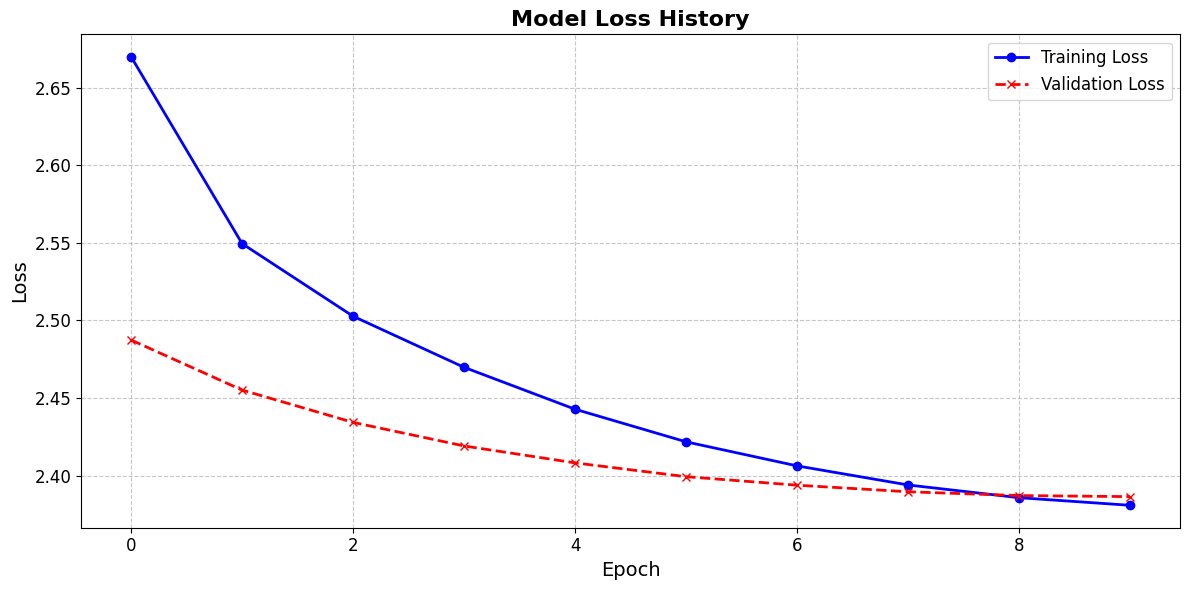

In [35]:
# Extract loss values from the log history
train_loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_values = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plot the loss values
plt.figure(figsize=(12, 6))
plt.plot(train_loss_values, label='Training Loss', marker='o', linestyle='-', color='b', linewidth=2, markersize=6)
plt.plot(eval_loss_values, label='Validation Loss', marker='x', linestyle='--', color='r', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Model Loss History', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [148]:
# Generate text
input_text = "dont know what to say"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# Generate sequences
model = model.to("cpu")
output = model.generate(input_ids, max_length=50, num_return_sequences=1, 
                        attention_mask=tokenizer(input_text, return_tensors="pt").attention_mask, do_sample=True,
                        no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=0.7, early_stopping=True, num_beams=2)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True,)

# Print generated text until the first period
print("Input Text       :", input_text)
print("Generated Text   :", generated_text.rsplit('.', 1)[0] + '.')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Input Text       : dont know what to say
Generated Text   : dont know what to say about this. Ive never heard of any such thing as an alt.atheism, but I do know that there are some who claim to be atheists, and that they believe in some kind of supernatural being.
